In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io


In [21]:

# Load data from .mat file (Assuming you have the data in mat format)
def load_data(filename):
    mat = scipy.io.loadmat(filename)
    anatomic = mat['res'][0, 0]['anaimage']
    csi = mat['res'][0, 0]['SepImage']
    return anatomic, csi


In [40]:

def normalize_csi_slice(csi_slice):
    csi_slice_abs = np.abs(csi_slice)  # Take the magnitude of the complex CSI data
    min_val = np.min(csi_slice_abs)
    max_val = np.max(csi_slice_abs)
    return (csi_slice_abs - min_val) / (max_val - min_val)  # Normalize to [0, 1]

In [5]:
# Display the anatomical overlay on a normalized CSI slice for a particular substance and scan
def plot_overlay(ax, anatomic, csi_slice, substance_name, scan_num, slice_num):
    ax.imshow(anatomic[:, :, slice_num], cmap='gray', alpha=0.5)  # Anatomical image with transparency
    ax.imshow(csi_slice, cmap='jet', alpha=0.7)  # Normalized CSI slice with color map and transparency
    ax.set_title(f'{substance_name} (Scan {scan_num}, Slice {slice_num})')
    ax.axis('off')  # Turn off axis for better visualization


In [48]:
# Overlay CSI on anatomical images for the selected slices and all scans
def overlay_csi_on_anatomic(anatomic, csi, anatomic_slice_idx, csi_slice_idx, substances, save_as=None):
    num_scans = csi.shape[4]  # Number of scans
    num_slices = csi.shape[2]  # Number of slices
    for substance_idx, substance in enumerate(substances): # Change this if you need to overlay a different substance (e.g., 0 for H2O, 1 for Glu, etc.)

        # Define number of rows and columns for displaying the overlay
        num_images_per_row = num_scans  # One column per scan
        num_rows = (num_slices + num_images_per_row - 1) // num_images_per_row  # Compute rows needed

        # Create figure for overlay
        fig, axes = plt.subplots(num_rows, num_images_per_row, figsize=(15, 5 * num_rows))

        # Flatten axes array to make indexing easier
        axes = axes.flatten()

        # Check if the number of axes matches the required total
        total_axes_needed = num_slices * num_scans
        if len(axes) < total_axes_needed:
            # If the axes are not enough, adjust the layout or add extra axes
            extra_axes_needed = total_axes_needed - len(axes)
            # Add extra subplots to match the required number of axes
            fig, axes = plt.subplots(num_rows, num_images_per_row + extra_axes_needed, figsize=(15, 5 * num_rows))
            axes = axes.flatten()

        for slice_num in range(num_slices):
            for scan_num in range(num_scans):
                # Extract CSI slice for the given substance and scan
                csi_slice = csi[:, :, :, substance_idx, scan_num]
                csi_slice_normalized = normalize_csi_slice(csi_slice[:, :, csi_slice_idx])

                # Apply rotation and flip to anatomical image before overlay
                rotated_flipped_anatomic = rotate_and_flip_image(anatomic[:, :, anatomic_slice_idx])

                # Select the correct axis for the current slice and scan
                ax = axes[slice_num * num_scans + scan_num]

                # Plot anatomical image and overlay CSI slice
                ax.imshow(rotated_flipped_anatomic, cmap='gray', alpha=0.5)  # Anatomical image with transparency
                ax.imshow(csi_slice_normalized, cmap='jet', alpha=0.7)  # Normalized CSI slice with transparency
                ax.set_title(f'Scan {scan_num + 1}, Slice {slice_num + 1}')
                ax.axis('off')

        plt.tight_layout()

        # Save the figure as a JPEG if a save path is specified
        if save_as:
            plt.savefig(save_as, format='jpeg', dpi=300)  # Save with 300 dpi for high quality
            print(f"Figure saved as {save_as}")

    plt.show()

In [7]:
# Calculate the average intensity for each ROI in the 3 substances (H2O, Glu, Lac)
def calculate_roi_intensity(csi, rois, substances, num_scans):
    roi_averages = {substance: [] for substance in substances}  # Dictionary to hold average intensities for each substance
    
    for roi in rois:
        for substance_idx, substance in enumerate(substances):
            roi_mask = roi  # Assuming roi is a mask (binary array where ROI pixels are 1)
            roi_values = []

            for scan_num in range(num_scans):  # Loop through each scan
                csi_slice = csi[:, :, :, substance_idx, scan_num]
                roi_values.append(np.mean(csi_slice[roi_mask]))  # Extract values within the ROI and calculate mean

            roi_averages[substance].append(np.mean(roi_values))  # Average across all scans

    return roi_averages

In [28]:
# Function to rotate image 90 degrees and flip it along the Y-axis
def rotate_and_flip_image(image):
    # Rotate the image 90 degrees
    rotated_image = np.rot90(image)
    # Flip the image along the Y-axis (vertical flip)
    flipped_image = np.flipud(rotated_image)
    return flipped_image

In [46]:

# Display the anatomical images for the selected slices only
def display_anatomic_images(anatomic, selected_slices,save_as=None):
    num_images_per_row = 4
    num_rows = (len(selected_slices) + num_images_per_row - 1) // num_images_per_row  # Calculate rows based on selected slices
    
    fig, axes = plt.subplots(num_rows, num_images_per_row, figsize=(15, 5 * num_rows))
    axes = axes.flatten()

    for idx, slice_num in enumerate(selected_slices):
        ax = axes[idx]
        # Apply rotation and flip before displaying
        rotated_flipped_image = rotate_and_flip_image(anatomic[:, :, slice_num])
        ax.imshow(rotated_flipped_image, cmap='gray')
        ax.set_title(f'Slice {slice_num + 1}')
        ax.axis('off')

    # Turn off remaining axes if there are fewer slices than spaces
    for i in range(len(selected_slices), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()

        # Save the figure as a JPEG if a save path is specified
    if save_as:
        plt.savefig(save_as, format='jpeg', dpi=300)  # Save with 300 dpi for high quality
        print(f"Figure saved as {save_as}")


    plt.show()

In [8]:
# Plot the average intensities of the 3 substances in the ROI
def plot_roi_intensities(roi_averages, rois, substances):
    num_rois = len(rois)
    x = np.arange(num_rois)

    # Create a new figure to display the average intensities
    fig, ax = plt.subplots(figsize=(10, 6))

    for substance in substances:
        ax.plot(x, roi_averages[substance], label=substance, marker='o')

    ax.set_title('Average Intensity of Substances in ROIs')
    ax.set_xlabel('ROI Index')
    ax.set_ylabel('Average Intensity')
    ax.set_xticks(x)
    ax.set_xticklabels([f'ROI {i+1}' for i in range(num_rois)])
    ax.legend()
    plt.tight_layout()
    plt.show()

In [22]:
# Load the data
anatomic, csi = load_data(r'C:\Users\nmruser\Desktop\Maya\Noise\20250511_101739_Maya_Mous6_exp2_gluc_SurfCoil_Maya_Mous6_ex_1_1\results_csi.mat')  # Replace with your file path


In [26]:
# Specify the number of slices to display (you can adjust this based on your data)
num_slices = anatomic.shape[2]  # Assuming 3D anatomical data, get the number of slices


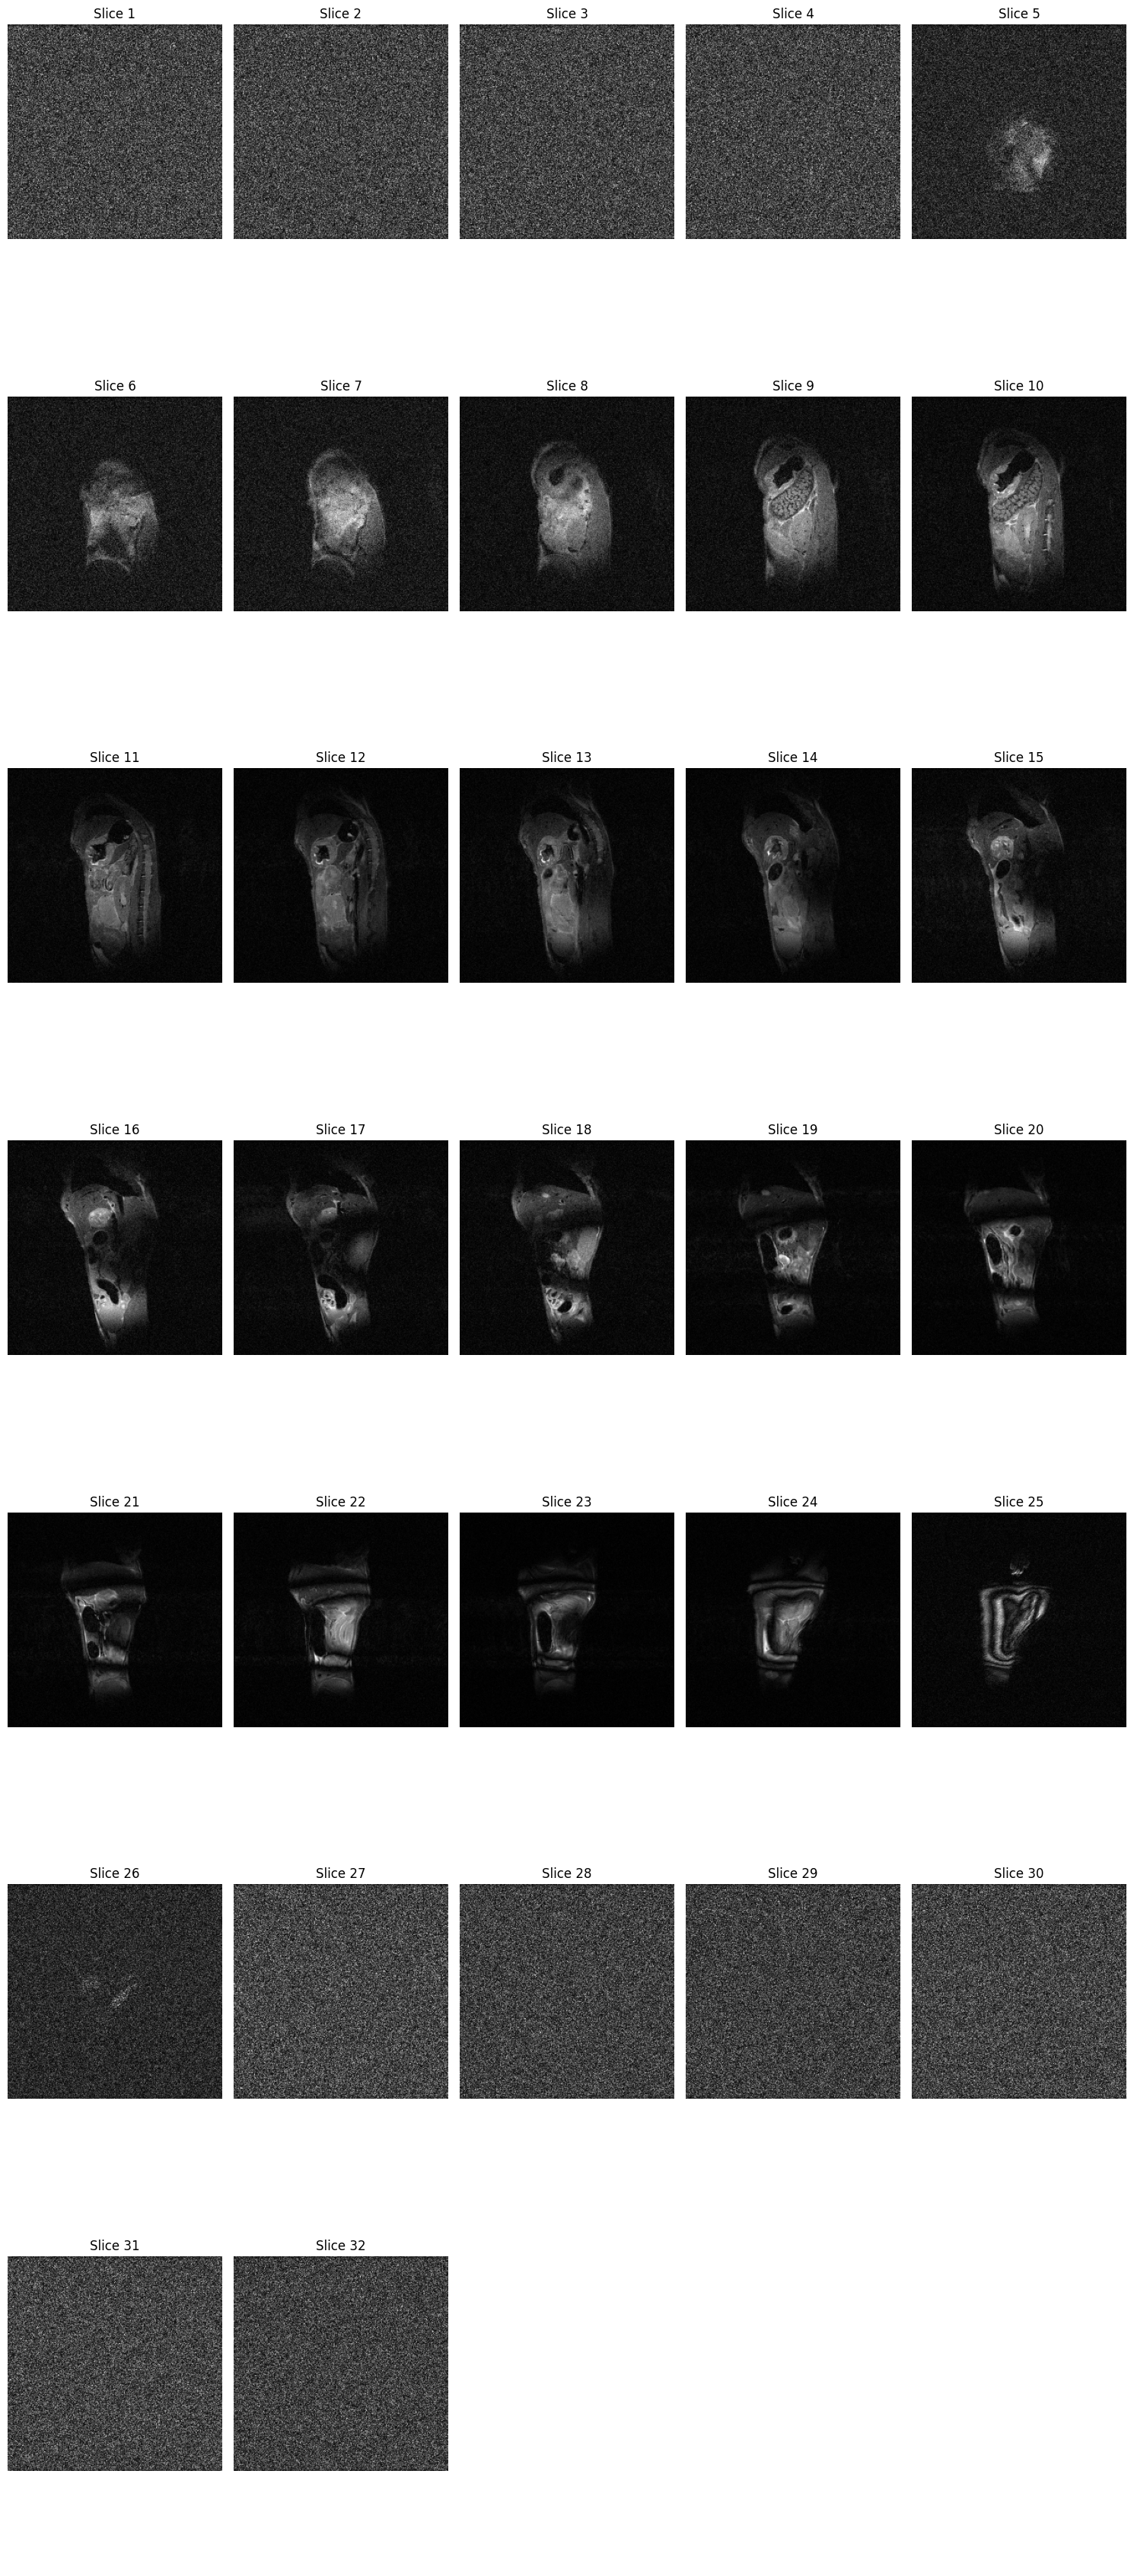

In [30]:
# Step 1: Display anatomical images for all slices
display_anatomic_images(anatomic, num_slices)

Figure saved as anatomic_slices.jpg


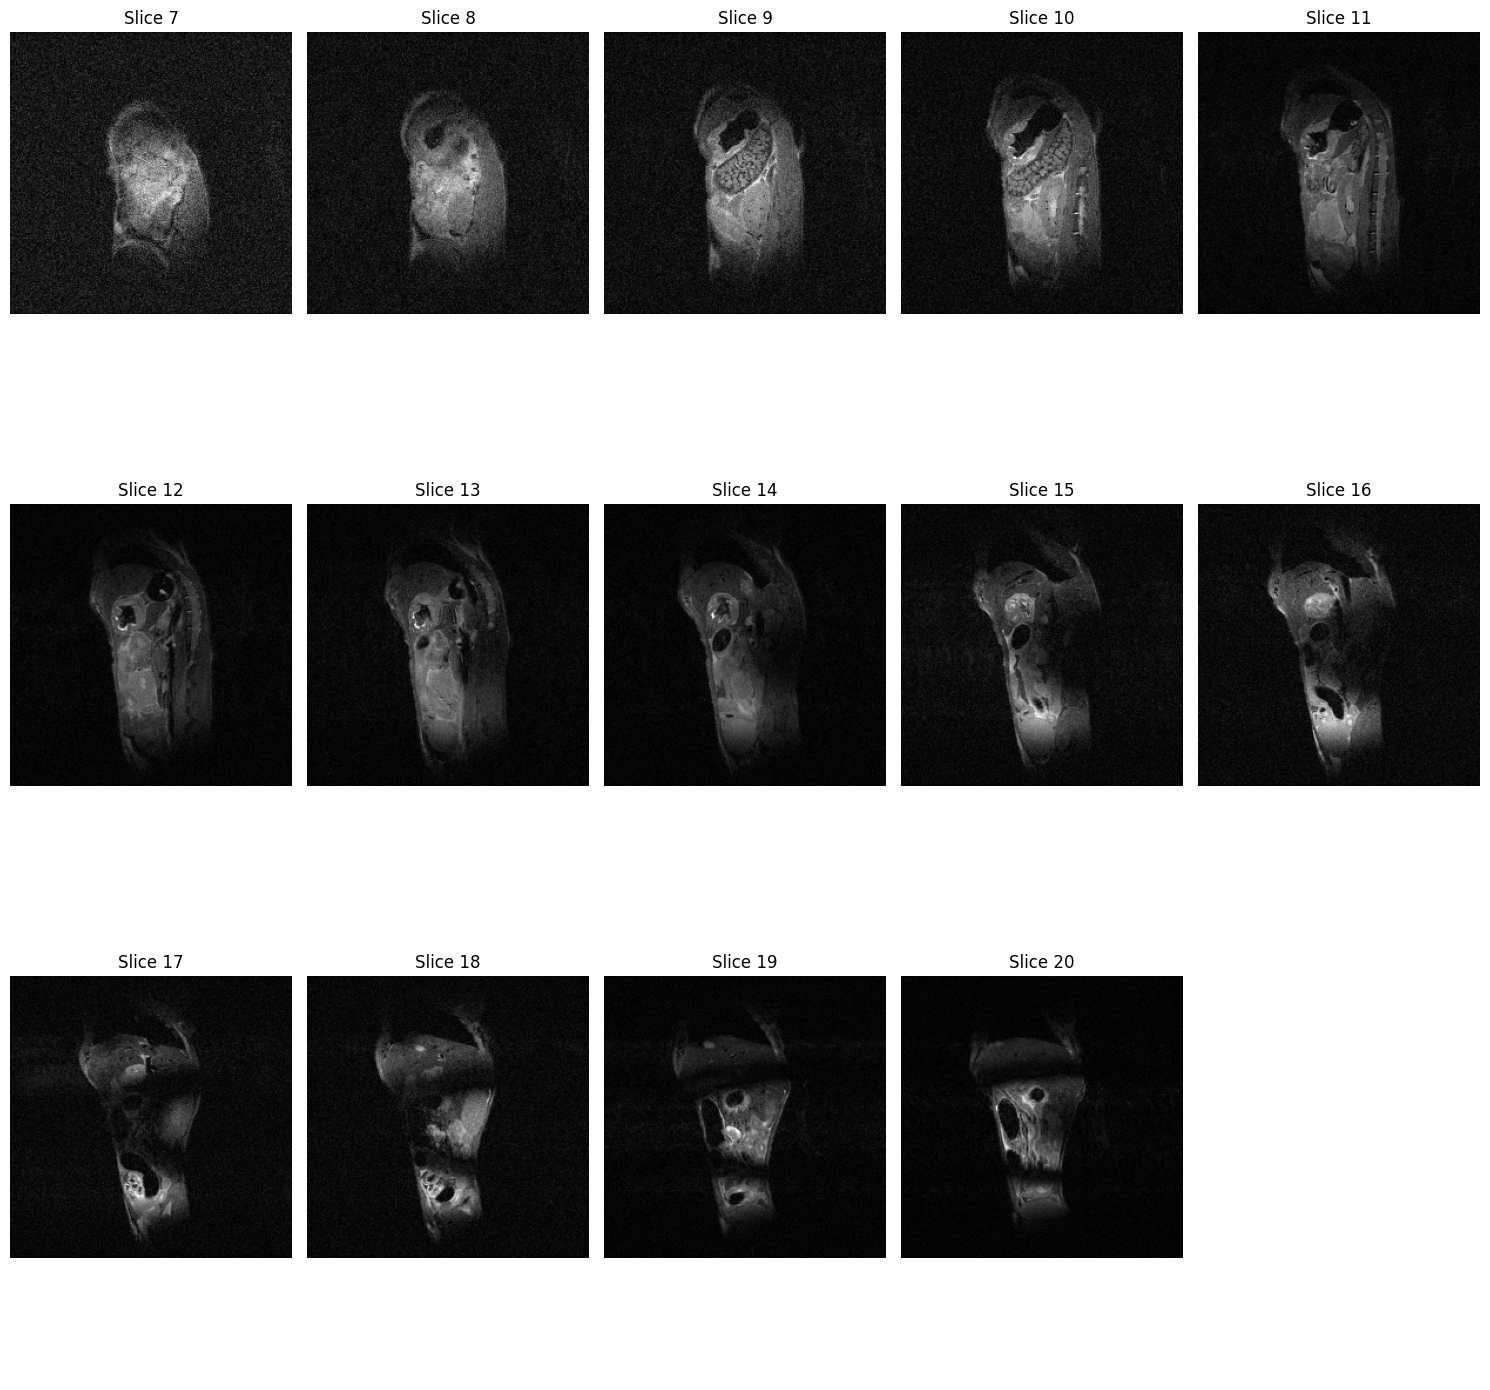

In [36]:
selected_slices = list(range(6, 20))
display_anatomic_images(anatomic, selected_slices, save_as='anatomic_slices.jpg')

In [14]:

# Define substances
substances = ['HDO', 'Glucose', 'Lactate']

C:\Users\nmruser\AppData\Local\Temp\ipykernel_8852\3163517530.py:44: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


Figure saved as overlay_slices.jpg


C:\Users\nmruser\AppData\Local\Temp\ipykernel_8852\3163517530.py:44: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


Figure saved as overlay_slices.jpg


C:\Users\nmruser\AppData\Local\Temp\ipykernel_8852\3163517530.py:44: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


Figure saved as overlay_slices.jpg


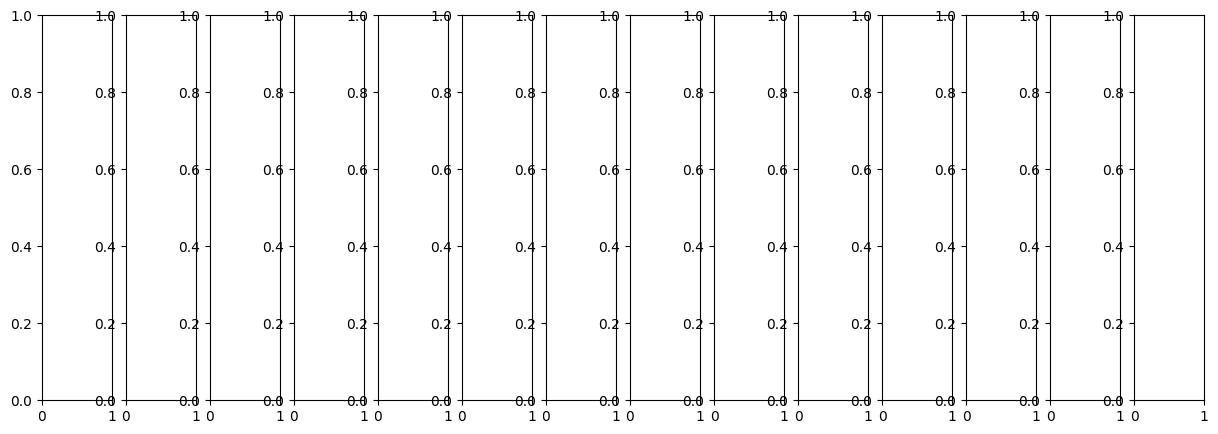

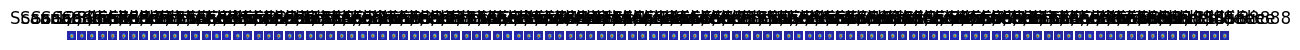

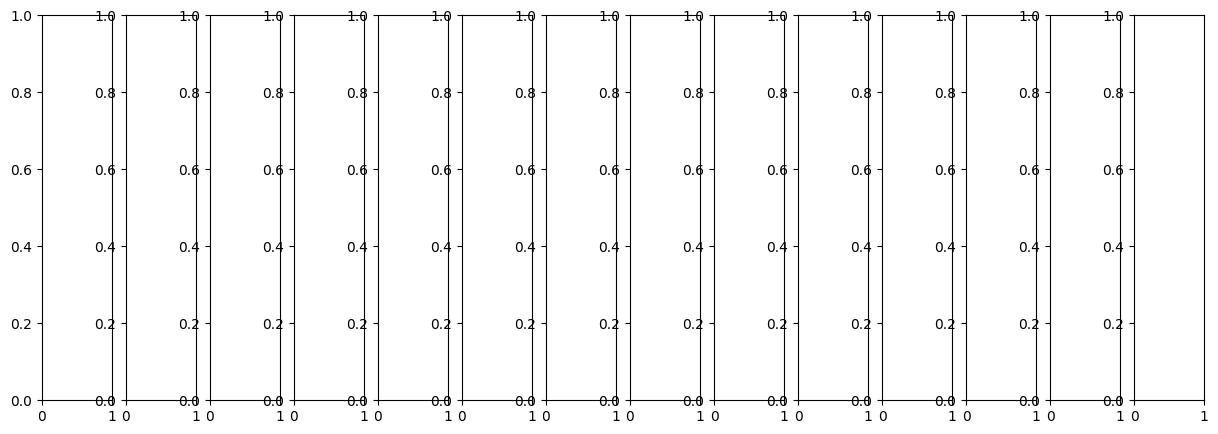

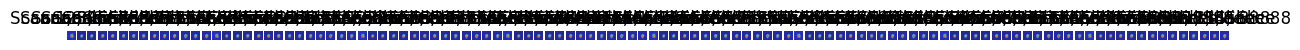

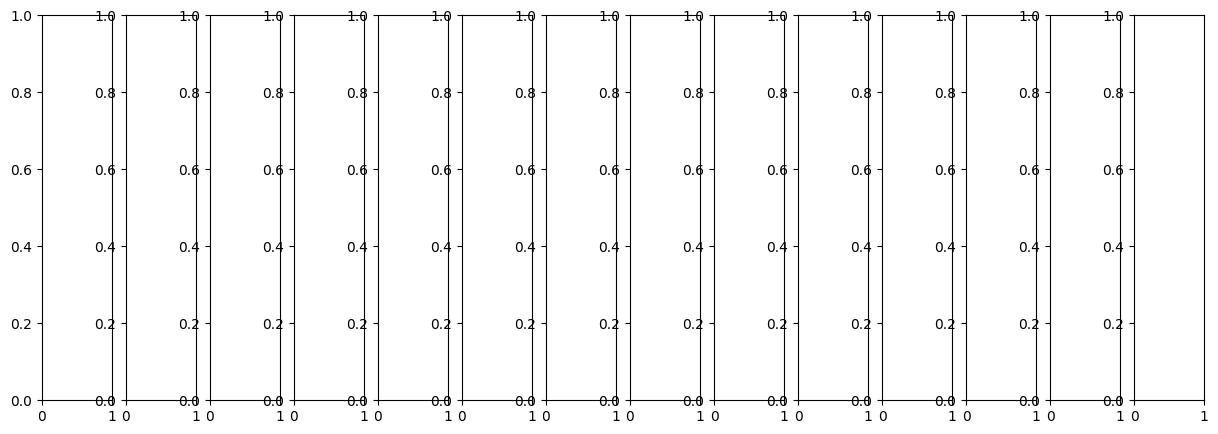

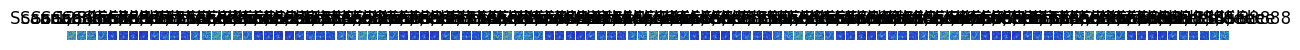

In [49]:

# Define anatomical slice and CSI slice (for example, slice 12 for anatomic, slice 13 for CSI)
anatomic_slice_idx = 11  # Anatomical slice index (12th slice, 0-based index)
csi_slice_idx = 3  # CSI slice index (13th slice, 0-based index)

# Display CSI overlays on the selected anatomical slice for all scans
overlay_csi_on_anatomic(anatomic, csi, anatomic_slice_idx, csi_slice_idx, substances, save_as='overlay_slices.jpg')  # Save as a JPEG


In [ ]:




# Define ROIs (example ROIs, you can replace these with actual ROIs)
# Each ROI is a binary mask where 1s represent the region and 0s represent the background.
rois = [anatomic > np.mean(anatomic), anatomic < np.mean(anatomic)]  # Example: define simple ROIs based on intensity


# Calculate and display average intensities within the ROIs
roi_averages = calculate_roi_intensity(csi, rois, substances, csi.shape[4])  # Calculate for all scans
plot_roi_intensities(roi_averages, rois, substances)  # Plot the results


